## Lassoの理論
Lassoの損失関数
$$L=argmin_w(\frac{1}{2n} ||y-Xw||^2_2 + \alpha||w||_1)$$

Lassoの更新式
$$\frac{\partial L}{\partial w} = \frac{1}{n}X^T(Xw-y)+\alpha$$
(但し、$\alpha$の符号はwに依存するため上記は適切な式を表現できていない。この処理は後程行うため、便宜上$\alpha$としている。)

上記の更新式をより具体的に書くと
$$\frac{\partial L}{\partial w} = 
\begin{pmatrix}
1 & \dots & 1 \\
x_{11} & \dots & x_{n1} \\
\vdots & \ddots & \vdots \\
x_{1d} & \dots & x_{nd} \\
\end{pmatrix}
\begin{pmatrix}
\sum_{j=0}^{d} w_j x_{1j} - y_1+\alpha\\
\sum_{j=0}^{d} w_j x_{2j} - y_2+\alpha\\
\vdots\\
\sum_{j=0}^{d} w_j x_{nj} - y_n+\alpha\\
\end{pmatrix}$$
$$ ∴\frac{\partial L}{\partial w_k} = \frac{1}{n}\sum_{i=1}^{n}(x_{ik}\sum_{j=1}^{d} w_j x_{ij} - y_i) +\alpha \hspace{20mm} (0≤k≤m)$$
Lの最小値が知りたいため、
$$ \frac{\partial L}{\partial w_k} = 0 $$
を$w_k$について解くと、
$$ \sum_{i=1}^{n} x_{ik} \sum_{j≠k}^{d} (w_j x_{ij} - y_i) + w_k x_{ik} + n\alpha = 0 $$
$$ \sum_{i=1}^{n}x_{ik}\sum_{j≠k}^{d} (w_j x_{ij} - y_i) + w_k \sum_{i=1}^{n}x_{ik}^2 + n\alpha = 0 $$
$$ ∴w_k = \frac{\sum_{i=1}^{n}x_{ik}\sum_{j≠k}^{d} (y_i - w_j x_{ij})-n\alpha}{\sum_{i=1}^{n}x_{ik}^2} $$

続いて、$\alpha$の符号についての処理を行う。そのため、右偏微分並びに左偏微分の場合わけを(軟判定しきい値関数で)行う。

右偏微分の式は以下の通りになる。
$$w_k^+ = \frac{\sum_{i=1}^{n}x_{ik}\sum_{j≠k}^{d} (y_i - w_j x_{ij})-n\alpha}{\sum_{i=1}^{n}x_{ik}^2}$$

左偏微分の式は以下の通りになる。
$$w_k^- = \frac{\sum_{i=1}^{n}x_{ik}\sum_{j≠k}^{d} (y_i - w_j x_{ij})+n\alpha}{\sum_{i=1}^{n}x_{ik}^2}$$

右偏微分の式はw>0の時に成立する式であるため、以下のような条件が成立する。
$$\frac{\sum_{i=1}^{n}x_{ik}\sum_{j≠k}^{d} (y_i - w_j x_{ij})-n\alpha}{\sum_{i=1}^{n}x_{ik}^2} > 0$$

同様のことが左偏微分の式にも言えるため、
$$\frac{\sum_{i=1}^{n}x_{ik}\sum_{j≠k}^{d} (y_i - w_j x_{ij})+n\alpha}{\sum_{i=1}^{n}x_{ik}^2} < 0$$
といった式が成立する。

よって、上記の二つの範囲に属さない範囲においては更新されない。
$$-n\alpha < \sum_{i=1}^{n}x_{ik}\sum_{j≠k}^{d} (y_i - w_j x_{ij}) < n\alpha$$

これがLassoにおいて重要性の低いパラメータを0とすることができる理由である。

## Lassoの実装

In [37]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Lasso as ori_Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [11]:
# 前処理
df.dropna(inplace=True)
df = pd.get_dummies(df, drop_first=True)

X = df.loc[:, df.columns!="Salary"]
y = df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
class Lasso(LassoCV):
  def __init__(self, alpha=1.0, max_iter=1000, positive = False):
    self.alpha_ = alpha
    self.max_iter = max_iter
    self.coef_ = None
    self.intercept_ = None
    self.positive = positive

  # 軟判定しきい値関数(を利用しやすく改善したもの)
  def SoftThr(self, top, bottom):
    if top > self.n * self.alpha_:
      return (top - self.n * self.alpha_) / bottom
    elif top < -self.n * self.alpha_ and not self.positive:
      return (top + self.n * self.alpha_) / bottom
    else:
      return 0

  # wの更新
  def update(self, X, y):
    # バイアスの更新
    self.intercept_ = sum((y - X@self.coef_)) / self.n
    for k in range(self.d):
      coef = self.coef_
      # Σ(j!=k)の実現 (上記説明文参照)
      coef[k] = 0
      top = (y - self.intercept_ - X@coef)@X[:, k]
      bottom = sum(X[:, k] ** 2)
      # 更新すべき範囲の値かどうかの判別
      self.coef_[k] = self.SoftThr(top, bottom)

  def fit(self, X, y):
    self.n, self.d = X.shape
    self.coef_ = np.zeros(self.d)
    for _ in tqdm(range(self.max_iter)):
      self.update(X, y)

  def predict(self, X):
    return X@self.coef_ + self.intercept_

  # 決定係数を元にして計算を行う。
  def score(self, X, y):
    return 1 - sum((y - self.predict(X)) ** 2) / sum((y - np.mean(y)) ** 2)


In [14]:
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [35]:
lasso = Lasso(alpha=0.1, positive=True)
lasso.fit(X_train, y_train)
lasso.intercept_, lasso.score(X_train, y_train)

100%|██████████| 1000/1000 [00:04<00:00, 231.26it/s]


(520.4853749999999, 0.41508082776971544)

In [36]:
ori_lasso = ori_Lasso(alpha=0.1, positive=True)
ori_lasso.fit(X_train, y_train)
ori_lasso.intercept_, lasso2.score(X_train, y_train)

(520.4853750000001, 0.41508081463529956)

In [33]:
from sklearn.metrics import mean_squared_error
mse_list = []
coefs = []
alphas = np.linspace(0.01,300,100)
for alpha in alphas:
  model = Lasso(alpha=alpha)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  mse_list.append(mse)
  coefs.append(model.coef_)

Text(0, 0.5, 'standardized coefficients')

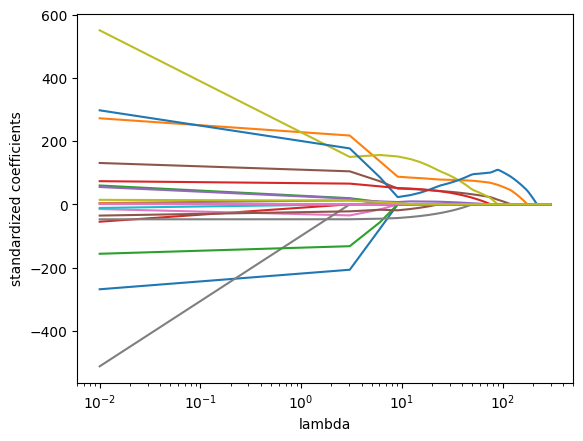

In [34]:
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('standardized coefficients')